#### Data Preprocessing

In [1]:
# Add all imports related to data engineering
import json
import numpy as np
import pandas as pd
import string
np.random.seed(2676)

In [2]:
# Import the training json file, then close the file
file = open("train.json")
raw_data = json.load(file)
file.close()

In [3]:
# Got the txt file from here: https://gist.github.com/deekayen/4148741

# Common words List to hold common words
with open("most-common-words.txt", "r") as common_words_file:
    common_tokens = [word[:-1] for word in list(common_words_file)]
    common_tokens.append("\n\n")
    common_tokens.append("\n")
    common_tokens.append(" ")

# Add punctuation to the list of commonalities
for char in list(string.punctuation):
    common_tokens.append(char)

print(common_tokens)

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I', 'his', 'they', 'be', 'at', 'one', 'have', 'this', 'from', 'or', 'had', 'by', 'not', 'word', 'but', 'what', 'some', 'we', 'can', 'out', 'other', 'were', 'all', 'there', 'when', 'up', 'use', 'your', 'how', 'said', 'an', 'each', 'she', 'which', 'do', 'their', 'time', 'if', 'will', 'way', 'about', 'many', 'then', 'them', 'write', 'would', 'like', 'so', 'these', 'her', 'long', 'make', 'thing', 'see', 'him', 'two', 'has', 'look', 'more', 'day', 'could', 'go', 'come', 'did', 'number', 'sound', 'no', 'most', 'people', 'my', 'over', 'know', 'water', 'than', 'call', 'first', 'who', 'may', 'down', 'side', 'been', 'now', 'find', 'any', 'new', 'work', 'part', 'take', 'get', 'place', 'made', 'live', 'where', 'after', 'back', 'little', 'only', 'round', 'man', 'year', 'came', 'show', 'every', 'good', 'me', 'give', 'our', 'under', 'name', 'very', 'through', 'just', 'form', 'sentence', 'g

In [4]:
# A function to get rid of the 1000 most common used words
def common_word_drop(token_list, whitespace_list, label_list, rows):
    for word in common_tokens:
        if word in token_list:
            indices = [i for i, x in enumerate(token_list) if x.lower() == word]
            token_list = [token_list[i] for i in range(len(token_list)) if i not in indices]
            whitespace_list = [whitespace_list[i] for i in range(len(whitespace_list)) if i not in indices]
            label_list = [label_list[i] for i in range(len(label_list)) if i not in indices]
            rows = [rows[i] for i in range(len(rows)) if i not in indices]

    return token_list, whitespace_list, label_list, rows

In [5]:
def get_rows(full_tokens):
    rows = []
    row_num = 1
    for token in full_tokens:
        rows.append(row_num)
        if token == "\n\n" or token == "\n":
            row_num = row_num + 1
    return rows

In [6]:
def pii_data_exists(labels):
    # Loop over and see if a PII data is found, if it is, return True, else False.
    for label in labels:
        if label != 'O':
            return True
    return False

In [7]:
def get_closest_label(labels):

    # Initialize the indexer and for all labels, find the indexes that have PII data
    label_indexes = []
    for i in range(len(labels)):
        if labels[i] != 'O':
            label_indexes.append(i)
    
    # If there is no PII data, if only one PII data, else multiple data
    if len(label_indexes) == 0:
        return [-1 for label in labels]
    elif len(label_indexes) == 1:
        label_range = [-1 for label in labels]
        label_range[label_indexes[0]] = 0
        return label_range
    else:
        label_range = [-1 for label in labels]

        # Get distance for first PII
        first_index = label_indexes[0]
        first_pii_distance = label_indexes[1] - label_indexes[0]
        label_range[first_index] = first_pii_distance

        # Get distance for last PII
        last_index = label_indexes[-1]
        last_pii_distance = label_indexes[-1] - label_indexes[-2]
        label_range[last_index] = last_pii_distance
        
        # Loop over the second to second last PII and get the distances.
        for idx in range(1, len(label_indexes)-1):

            # For the middle PII data points. Set the previous and next PII
            current_pii = label_indexes[idx]
            previous_pii = label_indexes[idx-1]
            next_pii = label_indexes[idx+1]

            # distances
            prev_dist = current_pii - previous_pii
            next_dist = next_pii - current_pii

            # Append the shortest distance to the current pii data
            label_range[current_pii] = min(prev_dist, next_dist)
        
        # Return the label range.
        return label_range

In [8]:
def engineer_data_for_model(data):

    # Get the first value from the data
    first_doc = data[0]

    # Get rid of common words
    all_rows = get_rows(first_doc['tokens'])
    tokens, white_spaces, labels, rows = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'], all_rows)
    closest_labels = get_closest_label(labels)

    # Create the initial dataframe from the above data
    first_doc_data = {
        "tokens": tokens,
        "trailing_whitespaces": white_spaces,
        "capitalized first char": [True if label[0].isupper() else False for label in tokens],
        "token length": [len(token) for token in tokens],
        "is_numeric": [True if token.isnumeric() else False for token in tokens],
        "PII label": labels,
        "Row": rows,
        "Closest PII data": closest_labels
    }
    raw_df = pd.DataFrame(first_doc_data)

    # Loop till the end of the data
    for document in data[1: len(data) - 1]:

        # Check to see if there exists PII data
        if not pii_data_exists(document['labels']):
            continue
            
        # Get rid of common words
        all_rows = get_rows(document['tokens'])
        tokens, white_spaces, labels, rows = common_word_drop(document['tokens'], document['trailing_whitespace'], document['labels'], all_rows)
        closest_labels = get_closest_label(labels)

        # Collect the data in the same way
        doc_data = {
            "tokens": tokens,
            "trailing_whitespaces": white_spaces,
            "capitalized first char": [True if label[0].isupper() else False for label in tokens],
            "token length": [len(token) for token in tokens],
            "is_numeric": [True if token.isnumeric() else False for token in tokens],
            "PII label": labels,
            "Row": rows,
            "Closest PII data": closest_labels
        }
        df = pd.DataFrame(doc_data)

        # Concatenate all the data into one single dataframe
        raw_df = pd.concat([raw_df, df], ignore_index=True, sort=False)

    # Return the concatenated dataframe
    return raw_df


In [9]:
# Get the training data and get rid of some unneeded number values
# data = engineer_data_for_model(raw_data[0:100])
data = engineer_data_for_model(raw_data)
data

,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label,Row,Closest PII data
0,Thinking,True,True,8,False,O,1,-1
1,innovation,True,False,10,False,O,1,-1
2,reflexion,False,False,9,False,O,1,-1
3,Avril,True,True,5,False,O,1,-1
4,2021,False,False,4,True,O,1,-1
...,...,...,...,...,...,...,...,...
276038,However,False,True,7,False,O,32,-1
276039,hindrance,True,False,9,False,O,32,-1
276040,stimulate,True,False,9,False,O,32,-1
276041,innovative,False,False,10,False,O,32,-1


In [10]:
# from sklearn.feature_extraction.text import HashingVectorizer

# hashing_vectorizer = HashingVectorizer(n_features=8, norm=None, alternate_sign=False)

# encoded_tokens = hashing_vectorizer.transform(data["tokens"]).toarray()

# encoded_tokens

In [11]:
# import hashlib

# hashed_values = [hashlib.sha1(row.tobytes()).hexdigest() for row in encoded_tokens]

# hashed_integers = [int(hash_val, 16) for hash_val in hashed_values]
# hashed_integers[0]

# data["hashed_tokens"] = hashed_integers
# data.astype({'hashed_tokens': 'int64'}).dtypes

# data

In [12]:
# Get the unique values of the PII data and print them.
unique_class_list = data["PII label"].unique().tolist()

# Need to get rid of the PII data that occurs less than 2 times because the model won't work wihout that.
for encoded_class in unique_class_list:

    # Get the occurence number for the current PII data and print the number
    class_numbers = len(data.loc[data["PII label"] == encoded_class, :])
    print(f"For PII data: {encoded_class}, there are {class_numbers} individual tokens")

    # For the number of occurences below 2, drop those rows.
    if class_numbers <= 2:
        data.drop(data.index[data["PII label"] == encoded_class].tolist(), axis=0, inplace=True)
        print(f"Deleted {encoded_class}")

data.reset_index(inplace=True)
    

For PII data: O, there are 273323 individual tokens
For PII data: B-NAME_STUDENT, there are 1364 individual tokens
For PII data: I-NAME_STUDENT, there are 1094 individual tokens
For PII data: B-URL_PERSONAL, there are 110 individual tokens
For PII data: B-EMAIL, there are 39 individual tokens
For PII data: B-ID_NUM, there are 78 individual tokens
For PII data: I-URL_PERSONAL, there are 1 individual tokens
Deleted I-URL_PERSONAL
For PII data: B-USERNAME, there are 6 individual tokens
For PII data: I-PHONE_NUM, there are 10 individual tokens
For PII data: B-STREET_ADDRESS, there are 2 individual tokens
Deleted B-STREET_ADDRESS
For PII data: I-STREET_ADDRESS, there are 14 individual tokens
For PII data: B-PHONE_NUM, there are 1 individual tokens
Deleted B-PHONE_NUM
For PII data: I-ID_NUM, there are 1 individual tokens
Deleted I-ID_NUM


In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode the multinomial label and add it as a column named "Y"
le = LabelEncoder()
data['Y'] = le.fit_transform(data['PII label'])

# Get the remaining PII and encoded labels
remaining_PII = data["PII label"].unique().tolist()
remaining_PII_encoded = data["Y"].unique().tolist()

# # Print the relevant data
print(remaining_PII)
print(remaining_PII_encoded)
print(f"The total number of rows: {len(data)}")
data

['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'B-EMAIL', 'B-ID_NUM', 'B-USERNAME', 'I-PHONE_NUM', 'I-STREET_ADDRESS']
[8, 2, 5, 3, 0, 1, 4, 6, 7]
The total number of rows: 276038


,index,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label,Row,Closest PII data,Y
0,0,Thinking,True,True,8,False,O,1,-1,8
1,1,innovation,True,False,10,False,O,1,-1,8
2,2,reflexion,False,False,9,False,O,1,-1,8
3,3,Avril,True,True,5,False,O,1,-1,8
4,4,2021,False,False,4,True,O,1,-1,8
...,...,...,...,...,...,...,...,...,...,...
276033,276038,However,False,True,7,False,O,32,-1,8
276034,276039,hindrance,True,False,9,False,O,32,-1,8
276035,276040,stimulate,True,False,9,False,O,32,-1,8
276036,276041,innovative,False,False,10,False,O,32,-1,8


#### Test/Train Splitting

In [14]:
from sklearn.model_selection import train_test_split

y = data["PII label"].to_numpy().tolist()

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=100, stratify=y)

In [15]:
# Train data
y_train = train_data["Y"].to_numpy()
X_train = train_data.drop(columns=["tokens", "PII label"])
print(f"Length train_x = {len(X_train)} \n Length y_train = {len(y_train)}")


# Test data
y_test = test_data["Y"].to_numpy()
X_test = test_data.drop(columns=["tokens", "PII label"])
print(f"Length test_x = {len(X_test)} \n Length test_y = {len(y_test)}")

Length train_x = 193226 
 Length y_train = 193226
Length test_x = 82812 
 Length test_y = 82812


In [16]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### Model Implementation

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import metrics

# Create and train the XGBoost Classifier
clf = XGBClassifier(n_estimators=100, random_state=42, enable_categorical=True)
clf.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
# Print the results
print('Training accuracy:', clf.score(scaled_X_train, y_train))
print('Test accuracy:', clf.score(scaled_X_test, y_test))

# Cross-validation
cv_scores = cross_val_score(clf, scaled_X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print('Cross-Validation Scores:', cv_scores)
print('Mean KFold Cross-Validation Accuracy:', cv_scores.mean())

# Classification Report
y_predictions = clf.predict(scaled_X_test)
print('\nClassification Report:')
print(classification_report(y_test, y_predictions))

Training accuracy: 1.0
Test accuracy: 1.0


C:\Users\vikyb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.99997412 1.         1.         1.         1.        ]
Mean KFold Cross-Validation Accuracy: 0.9999948248201627

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00       409
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00       328
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00     81998

    accuracy                           1.00     82812
   macro avg       1.00      1.00      1.00     82812
weighted avg       1.00      1.00      1.00     82812



#### Results Analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)
cnf_matrix

array([[   12,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,    23,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,   409,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,    33,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     2,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,   328,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     3,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     4,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0, 81998]],
      dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

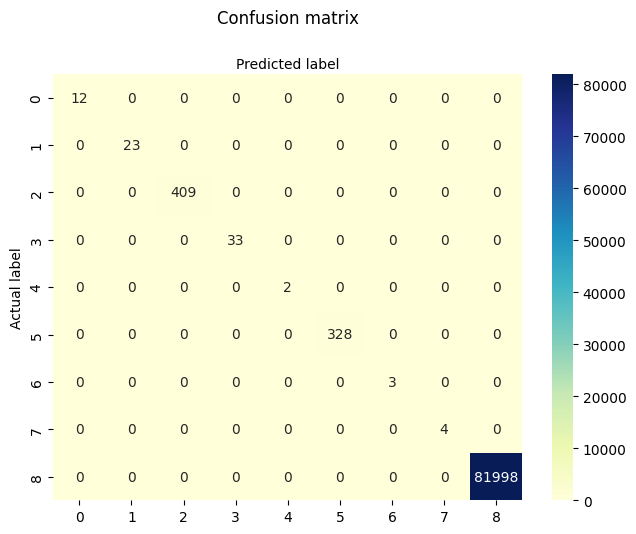

In [20]:
class_names = [0,1,2,3,4,5,6,7,8,9,10,11]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')